<a href="https://colab.research.google.com/github/lucasbarretto/Blood-Pressure-Estimation-MLP/blob/master/MLPNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blood Pressure Estimation MLP Network

Importing and preparing the data.

In [63]:
# clone dataset into google colab
!npx degit lucasbarretto/Blood-Pressure-Estimation-MLP/PyTorch_MLP -f

npx: installed 1 in 1.178s
> destination directory is not empty. Using --force, continuing
> cloned lucasbarretto/Blood-Pressure-Estimation-MLP#master


In [64]:
import pandas as pd

# import data and transpose rows to coumns
data = pd.read_csv('dataSet.csv', delimiter=',', header=None).transpose()
data.columns = ['PPG', 'ABP', 'ECG']

# print first 5 data samples to check if data is ok
data.head(5)

,PPG,ABP,ECG
0,1.3353,0.294720,134.860
1,1.5543,0.054741,102.720
2,2.5885,0.094819,85.135
3,2.9306,0.129520,76.734
4,1.3069,0.325020,109.120


In [13]:
data.describe()

,PPG,ABP,ECG
count,61000.000000,61000.000000,61000.000000
mean,1.839741,0.225842,94.657669
std,0.631981,0.254658,20.566709
min,0.000000,-0.240470,50.163000
25%,1.309900,0.089932,78.541000
50%,1.623700,0.184750,86.259000
75%,2.422300,0.304990,112.930000
max,4.002000,1.501000,160.110000


Split the data into training and testing set.

In [14]:
# split data into inputs (X) and targets (y)
feature_columns = ['PPG', 'ECG']
target_columns = ['ABP']

X = data[feature_columns]
y = data[target_columns]

# split data into train and test samples
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Normalize the data.

In [15]:
from sklearn.preprocessing import MinMaxScaler

# fit the scaler to training data only
X_scaler = MinMaxScaler()
X_train_normal = X_scaler.fit_transform(X_train)
X_test_normal = X_scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_train_normal = y_scaler.fit_transform(y_train)
y_test_normal = y_scaler.transform(y_test)

Build the Neural Network model.

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
    model = keras.Sequential([
        layers.Dense(200, kernel_initializer='uniform', activation='sigmoid',
                     input_shape=[len(feature_columns)]),
        layers.Dense(200, kernel_initializer='uniform', activation='sigmoid'),
        layers.Dense(200, kernel_initializer='uniform', activation='sigmoid'),
        layers.Dense(200, kernel_initializer='uniform', activation='sigmoid'),
        layers.Dense(len(target_columns), activation = 'sigmoid',
                     kernel_initializer='uniform')
    ])

    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse', 'mae'])

    return model

model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 200)               600       
_________________________________________________________________
dense_6 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_7 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_8 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 201       
Total params: 121,401
Trainable params: 121,401
Non-trainable params: 0
_________________________________________________________________


In [17]:
max_epochs = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(X_train_normal, y_train_normal, epochs=max_epochs, 
                    validation_split=0.2, batch_size=64,
                    callbacks=[early_stop])

Epoch 1/1000
534/534 [==============================] - 2s 4ms/step - loss: 0.0223 - mse: 0.0223 - mae: 0.0944 - val_loss: 0.0224 - val_mse: 0.0224 - val_mae: 0.0916
Epoch 2/1000
534/534 [==============================] - 2s 4ms/step - loss: 0.0219 - mse: 0.0219 - mae: 0.0915 - val_loss: 0.0218 - val_mse: 0.0218 - val_mae: 0.0910
Epoch 3/1000
534/534 [==============================] - 2s 4ms/step - loss: 0.0213 - mse: 0.0213 - mae: 0.0849 - val_loss: 0.0215 - val_mse: 0.0215 - val_mae: 0.0803
Epoch 4/1000
534/534 [==============================] - 2s 4ms/step - loss: 0.0209 - mse: 0.0209 - mae: 0.0822 - val_loss: 0.0212 - val_mse: 0.0212 - val_mae: 0.0857
Epoch 5/1000
534/534 [==============================] - 2s 4ms/step - loss: 0.0207 - mse: 0.0207 - mae: 0.0818 - val_loss: 0.0209 - val_mse: 0.0209 - val_mae: 0.0865
Epoch 6/1000
534/534 [==============================] - 2s 4ms/step - loss: 0.0201 - mse: 0.0201 - mae: 0.0823 - val_loss: 0.0209 - val_mse: 0.0209 - val_mae: 0.0813
Epoc

Plot loss curves.

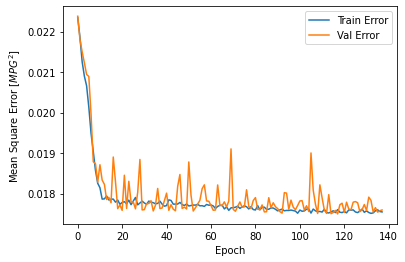

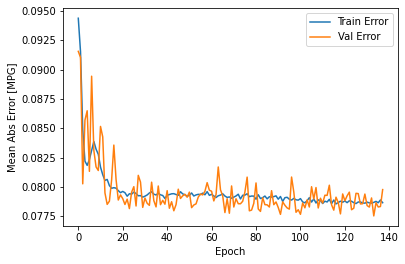

In [18]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
            label = 'Val Error')
    plt.legend()
    plt.show()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
            label = 'Val Error')
    plt.legend()

plot_history(history)

Calculate model score on test set.

In [20]:
score = model.evaluate(X_test_normal, y_test_normal, verbose=1)

572/572 [==============================] - 1s 2ms/step - loss: 0.0170 - mse: 0.0170 - mae: 0.0793


Plot the model prediction compared to the actual targets.

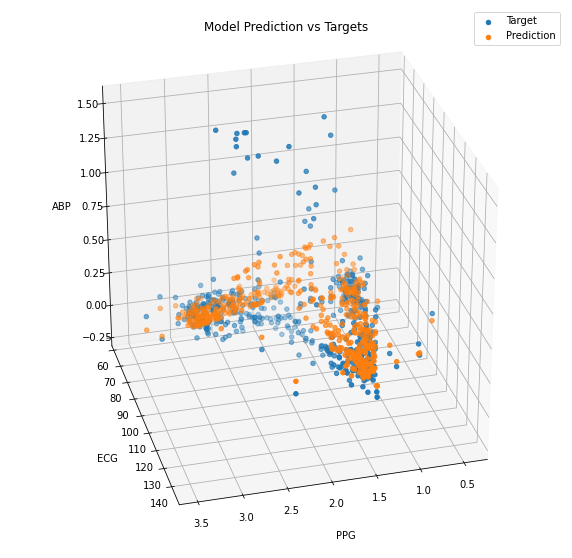

In [49]:
# make predictions on some samples
sample_size = 500
pred_normal = model.predict(X_test_normal[0:sample_size])

# denormalize prediction
pred = y_scaler.inverse_transform(pred_normal)

# plot targets
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test['PPG'][0:sample_size], X_test['ECG'][0:sample_size],
           y_test['ABP'][0:sample_size])
ax.scatter(X_test['PPG'][0:sample_size], X_test['ECG'][0:sample_size], pred)

ax.view_init(30, 75)
ax.set_xlabel('PPG', labelpad=15)
ax.set_ylabel('ECG', labelpad=15)
ax.set_zlabel('ABP', labelpad=15)
ax.legend(['Target', 'Prediction'])
plt.title('Model Prediction vs Targets', pad=20)
plt.show()